In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
data_dir = "Pet_Images"

In [7]:
full_dataset = ImageFolder(root=data_dir, transform=train_transform)

In [8]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [9]:
test_dataset.dataset.transform = test_transform

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
class_names = full_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Cat', 'Dog']


In [12]:
def show_samples(dataloader, num_samples=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        # Denormalize images
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

In [13]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # 2 classes: cat and dog
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


In [14]:
model = CatDogCNN().to(device)
print(model)

CatDogCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [18]:
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print("-" * 50)


Epoch 1/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  5.00it/s]


Train Loss: 0.9471, Train Acc: 0.6091
Test Loss: 0.6084, Test Acc: 0.6550
--------------------------------------------------
Epoch 2/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  5.02it/s]


Train Loss: 0.5812, Train Acc: 0.6862
Test Loss: 0.5148, Test Acc: 0.7470
--------------------------------------------------
Epoch 3/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.15it/s]


Train Loss: 0.5230, Train Acc: 0.7365
Test Loss: 0.4911, Test Acc: 0.7642
--------------------------------------------------
Epoch 4/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.07it/s]


Train Loss: 0.4851, Train Acc: 0.7654
Test Loss: 0.4828, Test Acc: 0.7626
--------------------------------------------------
Epoch 5/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.12it/s]


Train Loss: 0.4487, Train Acc: 0.7870
Test Loss: 0.4118, Test Acc: 0.8055
--------------------------------------------------
Epoch 6/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  4.89it/s]


Train Loss: 0.4160, Train Acc: 0.8067
Test Loss: 0.4966, Test Acc: 0.7788
--------------------------------------------------
Epoch 7/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.13it/s]


Train Loss: 0.3823, Train Acc: 0.8226
Test Loss: 0.3386, Test Acc: 0.8508
--------------------------------------------------
Epoch 8/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.11it/s]


Train Loss: 0.3614, Train Acc: 0.8359
Test Loss: 0.4209, Test Acc: 0.8253
--------------------------------------------------
Epoch 9/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.07it/s]


Train Loss: 0.3298, Train Acc: 0.8473
Test Loss: 0.3893, Test Acc: 0.8417
--------------------------------------------------
Epoch 10/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.26it/s]

Train Loss: 0.3118, Train Acc: 0.8562
Test Loss: 0.3061, Test Acc: 0.8734
--------------------------------------------------


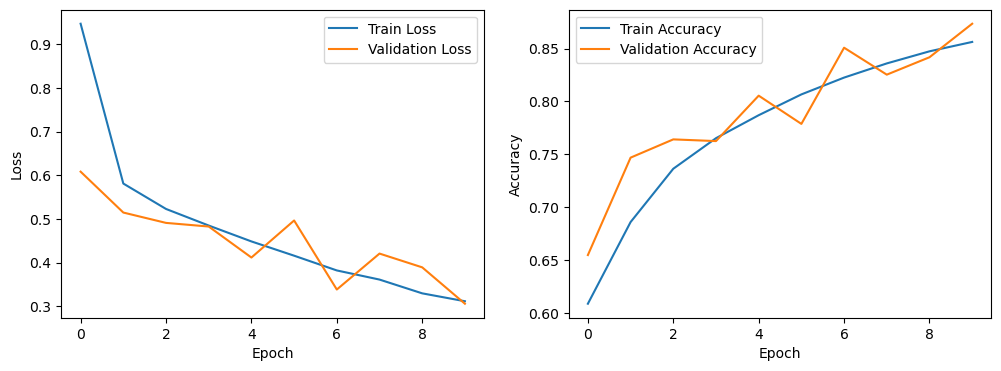

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), 'cat_dog_classifier.pth')
print("Model saved as cat_dog_classifier.pth")

Model saved as cat_dog_classifier.pth


In [21]:
def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return class_names[predicted.item()]

In [22]:
# Example of how to use the model for prediction
# Uncomment to use
# test_image_path = "path/to/test/image.jpg"
# prediction = predict_image(test_image_path, model, test_transform)
# print(f"Prediction: {prediction}")